# Example usage

This notebook will show how to get started with the `databallpy` package. The package is build around the `Match` class. All information about match is saved in this class. Amoung others, the class has attributes `tracking_data`, `event_data`, `home_players`, `away_score`, and `home_formation`. For more information on the `Match` class see our [documentation](https://databallpy.readthedocs.io/en/latest/autoapi/databallpy/index.html "databallpy documentation"). 

To use obtain a `Match` using `databallpy` in a project, run the following code:

In [1]:
import databallpy
print(databallpy.__version__)

0.3.1


In [2]:
# obtain a match object
from databallpy import get_match, get_open_match

# example of how to get match from private data:
# match = get_match(
#     tracking_data_loc=f"{location_to_tracking_data_file}",
#     tracking_metadata_loc=f"{location_to_tracking_metadata_file}",
#     tracking_data_provider=f"{tracking_data_provider}",
#     event_data_loc=f"{location_to_event_data_file}",
#     event_metadata_loc=f"{location_to_event_metadata_file}",
#     event_data_provider=f"{event_data_provider}"   
# )

# or use open metric data
match = get_open_match(verbose=False)
print(match)

databallpy.match.Match object: Team A 0 - 2 Team B 2019-02-21 03:30:07


Congrats, you have now loaded your first `Match` object! The `Match` is basically all the information you need to get started. Some basic preprocessing has already been done here:
- The x and y coordinates are scaled to the pitch dimensions in meters. If no pitch dimensions are available in the metadata, it is assumed that the pitch dimensions are 106 meters in the length (x-axis) and 68 meters in the width (y-axis).
- The center of the pitch is at position (0, 0)
- The home team is represented of playing from left to right the whole match, while the away team is represented to play from left to right the whole match. In this way you always now where eiter team wants to score.
- Some sanity checks on the tracking data are done to inform you about the quality of the data if it is not sufficient. For instance, if the kick off is not close to point (0, 0), there might have been a problem with the scaling of the field. Also, when players or the ball have have a impossible high velocity for over 1% of the match, a warning is raised. When a sanity check fails, the possibility of synchronising the tracking and event data is withdrawn since it greatly effects the quality of the synchronisation process.

Let's now take a look at all the data we have in our `Match`. Roughly speaking, a `Match` has information about the tracking data, the event data, and the metadata of the match. Let's start of with our tracking data:

# Tracking Data

In [3]:
print(type(match.tracking_data))
print(match.tracking_data.columns)
print(match.tracking_data[["frame", "ball_x", "ball_status", "home_11_x", "away_32_y", "period", "matchtime_td"]].head())

<class 'pandas.core.frame.DataFrame'>
Index(['frame', 'ball_x', 'ball_y', 'ball_z', 'ball_status', 'ball_possession',
       'home_11_x', 'home_11_y', 'home_1_x', 'home_1_y', 'home_2_x',
       'home_2_y', 'home_3_x', 'home_3_y', 'home_4_x', 'home_4_y', 'home_5_x',
       'home_5_y', 'home_6_x', 'home_6_y', 'home_7_x', 'home_7_y', 'home_8_x',
       'home_8_y', 'home_9_x', 'home_9_y', 'home_10_x', 'home_10_y',
       'away_28_x', 'away_28_y', 'away_18_x', 'away_18_y', 'away_19_x',
       'away_19_y', 'away_20_x', 'away_20_y', 'away_21_x', 'away_21_y',
       'away_22_x', 'away_22_y', 'away_23_x', 'away_23_y', 'away_24_x',
       'away_24_y', 'away_25_x', 'away_25_y', 'away_26_x', 'away_26_y',
       'away_27_x', 'away_27_y', 'home_12_x', 'home_12_y', 'home_13_x',
       'home_13_y', 'away_29_x', 'away_29_y', 'home_14_x', 'home_14_y',
       'away_31_x', 'away_31_y', 'away_32_x', 'away_32_y', 'away_30_x',
       'away_30_y', 'home_15_x', 'home_15_y', 'home_16_x', 'home_16_y',
       'aw

As you can see, the tracking data of a match is simply a pandas dataframe, making it easy to perform manipulation or filtering on the data. The tracking data has a few distinct columns:
- Frame information: Depending on the provider, the frame number will start at 1 or at a timestamp for that day. In this case, it starts at one and counts up as time proceeds.
- Ball information: `ball_x`, `ball_y`, and `ball_z` give information about the position of the ball on the pitch. Be cautious with `ball_z` since it often is poor quality data. `ball_status` is either `dead` or `alive`, indication whether the game is playing or not. `ball_possession` indicates what team has possession of the ball. The values can either be `home`, `away`, or `None`. For Metrica data it is put to `None` since the data does not indicate which team has possession.
- Player information: For every player the x and y coordinate are presented. The column name is based on the team the side the player plays for (either `home` or `away`), the jersey number of that player, and the type of data that is presented (x coordinate or y coordinate). The column name for the x-coordinate of the player that plays for the home team with jersey 12 is thus `home_12_x`.
- General match information: The `period_id` indicates what period of the match is played. A period id of `1` refers to the first half of the match, while `2` refers to the second half. The `matchtime_td` column gives the time in minutes:seconds of the match to give an indication of how far the match is along. It also tracks extra time, see the example below:

In [4]:
print(match.tracking_data[["frame", "ball_x", "ball_status", "home_11_x", "away_32_y", "period", "matchtime_td"]].tail())

         frame  ball_x ball_status  home_11_x  away_32_y  period matchtime_td
143756  143757     NaN        dead  -39.90735    8.39732       2   90:00+4:23
143757  143758     NaN        dead  -39.90735    8.43404       2   90:00+4:23
143758  143759     NaN        dead  -39.90735    8.48572       2   90:00+4:23
143759  143760     NaN        dead  -39.90735    8.57548       2   90:00+4:23
143760  143761     NaN        dead  -39.90735    8.94676       2   90:00+4:23


# Event Data

Since we have an idea of what our tracking data looks like and how it is formatted, let's now take a look at the event data:

In [5]:
print(type(match.event_data))
print(match.event_data.columns)

<class 'pandas.core.frame.DataFrame'>
Index(['event_id', 'type_id', 'databallpy_event', 'period_id', 'minutes',
       'seconds', 'player_id', 'player_name', 'team_id', 'outcome', 'start_x',
       'start_y', 'to_player_id', 'to_player_name', 'end_x', 'end_y',
       'td_frame', 'metrica_event', 'datetime'],
      dtype='object')


Again, you can see that we are just dealing with a familiar pandas dataframe, not to be afraid of. Let's go through all the columns before we take a look at the data:
- `event_id`: an unique id (usually an integer) for the event.
- `type_id`: an id indicating the type of event.
- `databallpy_event`: a string indicating the event. Since we aim to create a standardized format of event data, we need to translate the event data from the provider, in this case Metrica, to a standard event type, in this case that is `databallpy_event`. It currently can only have the values `pass`, `shot`, or `dribble`. For any other event, the value will be `None`. We aim to increase the number of databallpy events in future versions to be more complete.
- `period_id`: the period that the event happened in. `1` indicating the first half and `2` the second half.
- `minutes`: the number of minutes in the match at the time of the event.
- `seconds`: the number of seconds in the match at the time of the event.
- `player_id`: an unique id of the player involved in the event.
- `player_name`: a string with the name of the player.
- `team_id`: an unique id for which team the event belonged to.
- `outcome`: a boolian indicating if the `databallpy_event` was successful (`True`) or not (`False`).
- `start_x` and `start_y`: the coordinate, indicated by the event data provider, where the event took place. Note that these coordinates are scaled to fit the tracking data.
- `metrica_event`: Since `databallpy_event` may not capture all events, we always keep in the original event data of the provider to make sure no data is lost in the process.
- `datetime`: a datatime object used to indicate when the event took place.

As you probably have notices, I skipped a few columns. That is because these columns are specific for Metrica, not all event data providers provide this data, and therefore these columns are not present in all event data dataframes.
- `to_player_id` and `to_player_name`: Metrica sometimes indicate to which player the ball was passed. Since metrica indicates this information, we add it in the dataframe, but this column is not present for event data providers that do not indicate this in their data.
- `end_x` and `end_y`: the coordinate, indicated by the event data provider, where the event ended. Note that these coordinates are scaled to fit the tracking data. Also, this is again Metrica specific data, not all event data providers provide this data.
- `td_frame`: since this match uses tracking and event data from `Metrica`, the two are already synchronised. The `td_frame` indicates what frame in the tracking data belongs to the event to get contextual information of that event.


Here is an example of what an event in the event data looks like:

In [6]:
print(match.event_data.iloc[13])

event_id                                          14
type_id                                            1
databallpy_event                                pass
period_id                                          1
minutes                                            0
seconds                                        28.88
player_id                                       3570
player_name                                 Player 3
team_id                                      FIFATMA
outcome                                            1
start_x                                     -32.9574
start_y                                    -24.63232
to_player_id                                    3578
to_player_name                             Player 11
end_x                                      -48.33255
end_y                                       -8.37284
td_frame                                         722
metrica_event                                   pass
datetime            2019-02-21 03:30:35.840000

# Metadata

We are now only missing the metadata of the match. Most of the metadata speaks for itselfs, but let's just go through it:

In [7]:
print(match.pitch_dimensions)
print(match.periods.iloc[0])
print(match.frame_rate)
print(match.home_team_id, match.away_team_id)
print(match.home_team_name, match.away_team_name)
print(match.home_score, match.away_score)
print(match.home_formation, match.away_formation)
print(match.allow_synchronise_tracking_and_event_data)

[105.0, 68.0]
period                                              1
start_frame                                         1
end_frame                                       69661
start_datetime_td           2019-02-21 03:30:07+00:00
end_datetime_td      2019-02-21 04:16:33.400000+00:00
start_datetime_ed           2019-02-21 03:30:07+00:00
end_datetime_ed      2019-02-21 04:16:33.400000+00:00
Name: 0, dtype: object
25
FIFATMA FIFATMB
Team A Team B
0 2
1451 1442
True


As you can see, `periods` is also a pandas dataframe, with for every period a row. This could be usefull if you want to check how the tracking and event data "starts" at a different time. However, since the event and tracking data is here both from Metrica, the start and end datetimes are identical for the event and tracking  data. The formation of both teams is captured in a string. Team 1 plays 1-4-5-1 and team 2 1-4-4-2.

We are still missing one crucial piece of information: information about the players. This is also captured in a dataframe:

In [8]:
print(match.home_players.iloc[0])

id                       3578
full_name           Player 11
formation_place             0
position           goalkeeper
starter                  True
shirt_num                  11
start_frame              -999
end_frame                -999
Name: 0, dtype: object


The dataframe holds information about the id, full name, position, shirt number, and if the data is available, at what tracking data frame the player enters and leaves the pitch. In this case the data is not available. `-999` is the integer indicating a missing value. For floats we use `np.nan` and for string or objects `None` to indicate a missing value.

So thats it? Now we have it all? Of course not, now we can get started, let me show you a few examples.

# Synchronising tracking and event data

to synchronise tracking and event data (for instance when the tracking and event data provider differ) you can simply run:

In [9]:
match.synchronise_tracking_and_event_data(verbose=False)
print(match.tracking_data.columns)

Index(['frame', 'ball_x', 'ball_y', 'ball_z', 'ball_status', 'ball_possession',
       'home_11_x', 'home_11_y', 'home_1_x', 'home_1_y', 'home_2_x',
       'home_2_y', 'home_3_x', 'home_3_y', 'home_4_x', 'home_4_y', 'home_5_x',
       'home_5_y', 'home_6_x', 'home_6_y', 'home_7_x', 'home_7_y', 'home_8_x',
       'home_8_y', 'home_9_x', 'home_9_y', 'home_10_x', 'home_10_y',
       'away_28_x', 'away_28_y', 'away_18_x', 'away_18_y', 'away_19_x',
       'away_19_y', 'away_20_x', 'away_20_y', 'away_21_x', 'away_21_y',
       'away_22_x', 'away_22_y', 'away_23_x', 'away_23_y', 'away_24_x',
       'away_24_y', 'away_25_x', 'away_25_y', 'away_26_x', 'away_26_y',
       'away_27_x', 'away_27_y', 'home_12_x', 'home_12_y', 'home_13_x',
       'home_13_y', 'away_29_x', 'away_29_y', 'home_14_x', 'home_14_y',
       'away_31_x', 'away_31_y', 'away_32_x', 'away_32_y', 'away_30_x',
       'away_30_y', 'home_15_x', 'home_15_y', 'home_16_x', 'home_16_y',
       'away_33_x', 'away_33_y', 'away_34_x', 'a

Now, `databallpy_event` and `event_id` are added to the tracking data, indicating when and what kind of event happens. The corresponding tracking data frame can now also be found in the event_data. 

Note: you can see also information about the ball velocity and acceleration is added to the tracking data. This information is used in the cost function to find the optimal alignment between the tracking data and the event data. For instance, you know that there must be a high acceleration of the ball when someone shoots it.

# Databallpy events

The use of databallpy events has some added value. Since we know exactly what event we are talking about, we can collect additional information about the event. For instance, you can find information about a shot while looking in the event data, but that might not be enough for you. Maybe you want to make a expected goal model and use tracking data to get more information out of the data. We already did this for you a little. Simply look into our `shots_df` (we also have a `dribbles_df` and a `passes_df`:

In [10]:
print(match.shots_df.columns)
print(match.shots_df.iloc[0])

Index(['event_id', 'player_id', 'period_id', 'minutes', 'seconds', 'datetime',
       'start_x', 'start_y', 'team_id', 'shot_outcome', 'y_target', 'z_target',
       'body_part', 'type_of_play', 'first_touch', 'created_oppertunity',
       'related_event_id', 'ball_goal_distance', 'ball_gk_distance',
       'shot_angle', 'gk_angle', 'pressure_on_ball', 'n_obstructive_players'],
      dtype='object')
event_id                                              131
player_id                                            3574
period_id                                               1
minutes                                                 3
seconds                                             53.16
datetime                 2019-02-21 03:34:00.120000+00:00
start_x                                          29.23725
start_y                                          16.09968
team_id                                           FIFATMA
shot_outcome                                         miss
y_target         

If available in the event data, we store here information about the body part, relateded event id and type of play (e.g. did the shot originate from a set piece or not). But we also already added some extra information based on the synchronised tracking and even data.

# Add features to the data

Having data is one thing, but you want to enrich the data. For that, you might want to add features to the data. The available possibilities we have right now are the following:
- get the pressure on the ball (Herrold et al., 2022)
- get the individual player possession (Adrienko et al., 2016)
- get the velocity, acceleration (and jerk) of players and the ball.
- filter the data

For specific use cases look at our official documentation, lets give you an example with individual player possession:


In [11]:
from databallpy.features.player_possession import get_individual_player_possessions_and_duels

possessions, duels = get_individual_player_possessions_and_duels(
    tracking_data=match.tracking_data,
    frame_rate=match.frame_rate,
    pz_radius=1.0, # the possession zone radius
    dz_radius=1.0, # the duel zone radius
    bv_threshold=5.0, # the ball velocity change threshold
    ba_threshold=10.0, # the ball angle change threshold
    bd_threshold=0.1, # the ball displacement change threshold
    min_frames=0, # number of frames there need to be before a ball possession can be assigned
)

match.tracking_data["player_possession"] = possessions
print(match.tracking_data["player_possession"].value_counts())


player_possession
home_7     3429
home_6     3219
home_1     2881
away_19    2786
home_3     2662
away_28    2439
home_4     2437
away_20    2343
away_24    2323
away_29    1751
away_22    1705
home_5     1624
away_23    1530
home_11    1521
away_21    1396
home_12    1370
home_2     1315
away_25    1250
home_15    1161
away_18     825
away_27     811
away_33     788
home_9      775
home_8      767
home_10     742
away_26     717
away_30     700
away_31     676
home_13     653
home_16     551
away_34     451
home_17     422
home_14     398
away_32     254
away_35     104
Name: count, dtype: int64


# Save Match Clip

Another functionality is in saving match clips of the tracking and event data. Since we have already synchronised the tracking and event data, we can now also indicate which events we want to see in the match clip. On top of that, we also just added player possession to our data, lets check how well it worked by adding a yellow circle around the proposed player that has ball possession. To save a match clip, run the following code:

In [42]:
from databallpy.visualize import save_match_clip

# saving match clip from the index 1065 to 1565, with a frame rate of 25 fps (20 seconds of the match).
save_match_clip(match, 1085, 1585, save_folder="example_data", title="example", events=["pass"],  verbose=False, player_possession_column="player_possession")

In [8]:
from IPython.display import HTML

HTML("""
    <video alt="save match clip" width="640" height="480" controls>
        <source src="https://raw.githubusercontent.com/Alek050/databallpy/main/docs/example_data/example.mp4" type="video/mp4">
    </video>
""")

As you can see, the event synchronisation and the individual player possessions work pretty good.

# Plot events

Also, events can be plotted. You can specify the event, the outcome, the player, and the team. For instance, if you want all shots plotted, colored by which team took the shot, you can use the following code:

Note that because the home team (Team A) is always represented playing from left to right, all shots of the match (both first and second half) are represented on the right side of the pitch. 

Found 20 matching events


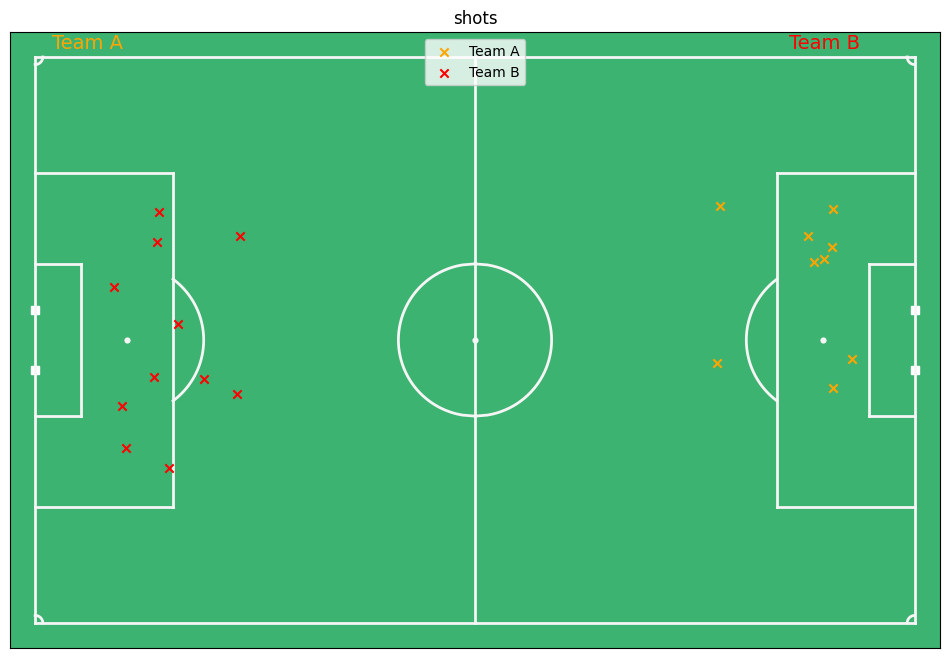

In [35]:
from databallpy.visualize import plot_events
import matplotlib.pyplot as plt

fig, ax = plot_events(match, events=["shot"], color_by_col="team_id", title="shots")
plt.show()

# Conclusion

Hope you have an idea of how the package works and how it can speed up your analysis of soccer matches. However, we are still in development, so if you have any suggestion, bugs, warnings, things you don't understand and/or just want to contribute to the package, don't hesitate to go to the [GitHub page](https://github.com/Alek050/databallpy) of the project and open an issue/question or just let us know what you think of the package!